In [ ]:
virtualenv -p python3 envname
Source venv/bin/activate
pip install ipykernel
ipython kernel install --user --name=cv_meetup
pip install tensorflow = 1.13.1
pip install matplotlib
pip install pillow

In [1]:
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from IPython.display import Image,display

In [2]:
print(tf.__version__)

1.13.1


Download the Dataset from this link https://www.kaggle.com/c/dogs-vs-cats/data

In [3]:
Data_path ="catsVSdogs/train/"
train_data_files = os.listdir(Data_path)
path = 'model_outputs/'

In [4]:
def get_one_hot_label(train_image):
    if "cat" in train_image:
        return [1,0]
    else:
        return [0,1]

In [5]:
def get_data():
    
    trainX,trainY = [],[]
    
    for train_image in train_data_files:
        
        trainX.append(image.img_to_array(image.load_img(Data_path+train_image, target_size=(64, 64)))/255)
        trainY.append(get_one_hot_label(train_image))
    
    return np.array(trainX),np.array(trainY)

In [6]:
trainX,trainY = get_data()
print(trainX.shape , trainY.shape)

(25000, 64, 64, 3) (25000, 2)


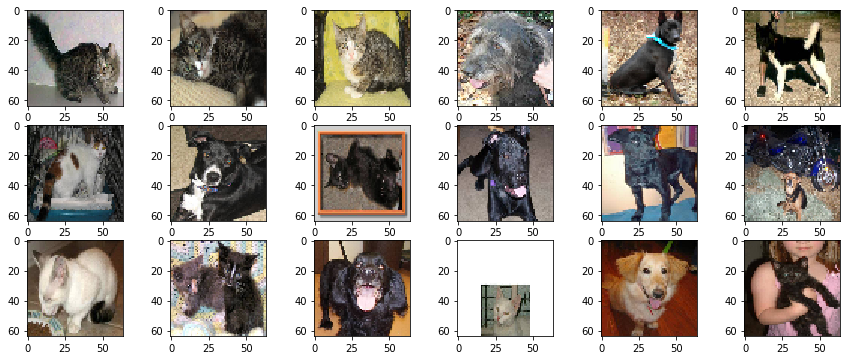

In [7]:
fig=plt.figure(figsize=(15, 6))
columns = 6
rows = 3
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(trainX[i])
plt.show()

In [8]:
def model(inputs):
    
    
    with tf.variable_scope('conv1') as scope:
        weights = tf.get_variable('weights',
                                  shape = [3,3,3, 16],
                                  dtype = tf.float32, 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1,dtype=tf.float32))
        biases =  tf.get_variable('biases',
                                  shape=[16],
                                  dtype=tf.float32,
                                  initializer=tf.constant_initializer(0.1))

        conv = tf.nn.conv2d(inputs, weights, strides=[1,1,1,1], padding='SAME')
        add_bias = tf.nn.bias_add(conv, biases)

        conv1 = tf.nn.relu(add_bias, name= scope.name)

        pool1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1],strides=[1,2,2,1],
                               padding='SAME', name='pooling1')
        

    with tf.variable_scope("conv2") as scope:
        
        weights = tf.get_variable("weights",
                                 shape = [3,3,16,32],
                                 dtype = tf.float32,
                                 initializer = tf.truncated_normal_initializer(stddev=0.1,dtype = tf.float32))
        biases =  tf.get_variable("biases",
                                 shape = [32],
                                 dtype = tf.float32,
                                 initializer = tf.constant_initializer(0.1))

        conv = tf.nn.conv2d(pool1,weights,strides=[1,1,1,1],padding = "SAME")
        add_bias = tf.nn.bias_add(conv,biases)

        conv2 = tf.nn.relu(add_bias,name = "conv2")

        pool2 = tf.nn.max_pool(conv2,ksize=[1,3,3,1], strides=[1,1,1,1],
                               padding='SAME',name='pooling2')

    with tf.variable_scope('fc3') as scope:
        
        layer_shape = pool2.get_shape()
        num_features = layer_shape[1:4].num_elements()
        flatten_layer = tf.reshape(pool2, [-1, num_features])
    
        flatten_dim = flatten_layer.get_shape()[1]

        weights = tf.get_variable('weights',
                                  shape=[flatten_dim,128],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases =  tf.get_variable('biases',
                                  shape=[128],
                                  dtype=tf.float32, 
                                  initializer=tf.constant_initializer(0.1))

        fc3 = tf.nn.relu(tf.matmul(flatten_layer, weights) + biases, name=scope.name)    

    with tf.variable_scope('fc4') as scope:
        weights = tf.get_variable('weights',
                                  shape=[128,128],
                                  dtype=tf.float32, 
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[128],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        fc4 = tf.nn.relu(tf.matmul(fc3, weights) + biases, name='fc4')


    with tf.variable_scope('output') as scope:

        weights = tf.get_variable('weights5',
                                  shape=[128, 2],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases5', 
                                 shape=[2],
                                 dtype=tf.float32, 
                                 initializer=tf.constant_initializer(0.1))
        logits = tf.add(tf.matmul(fc4, weights), biases, name='final_logits')


    return logits

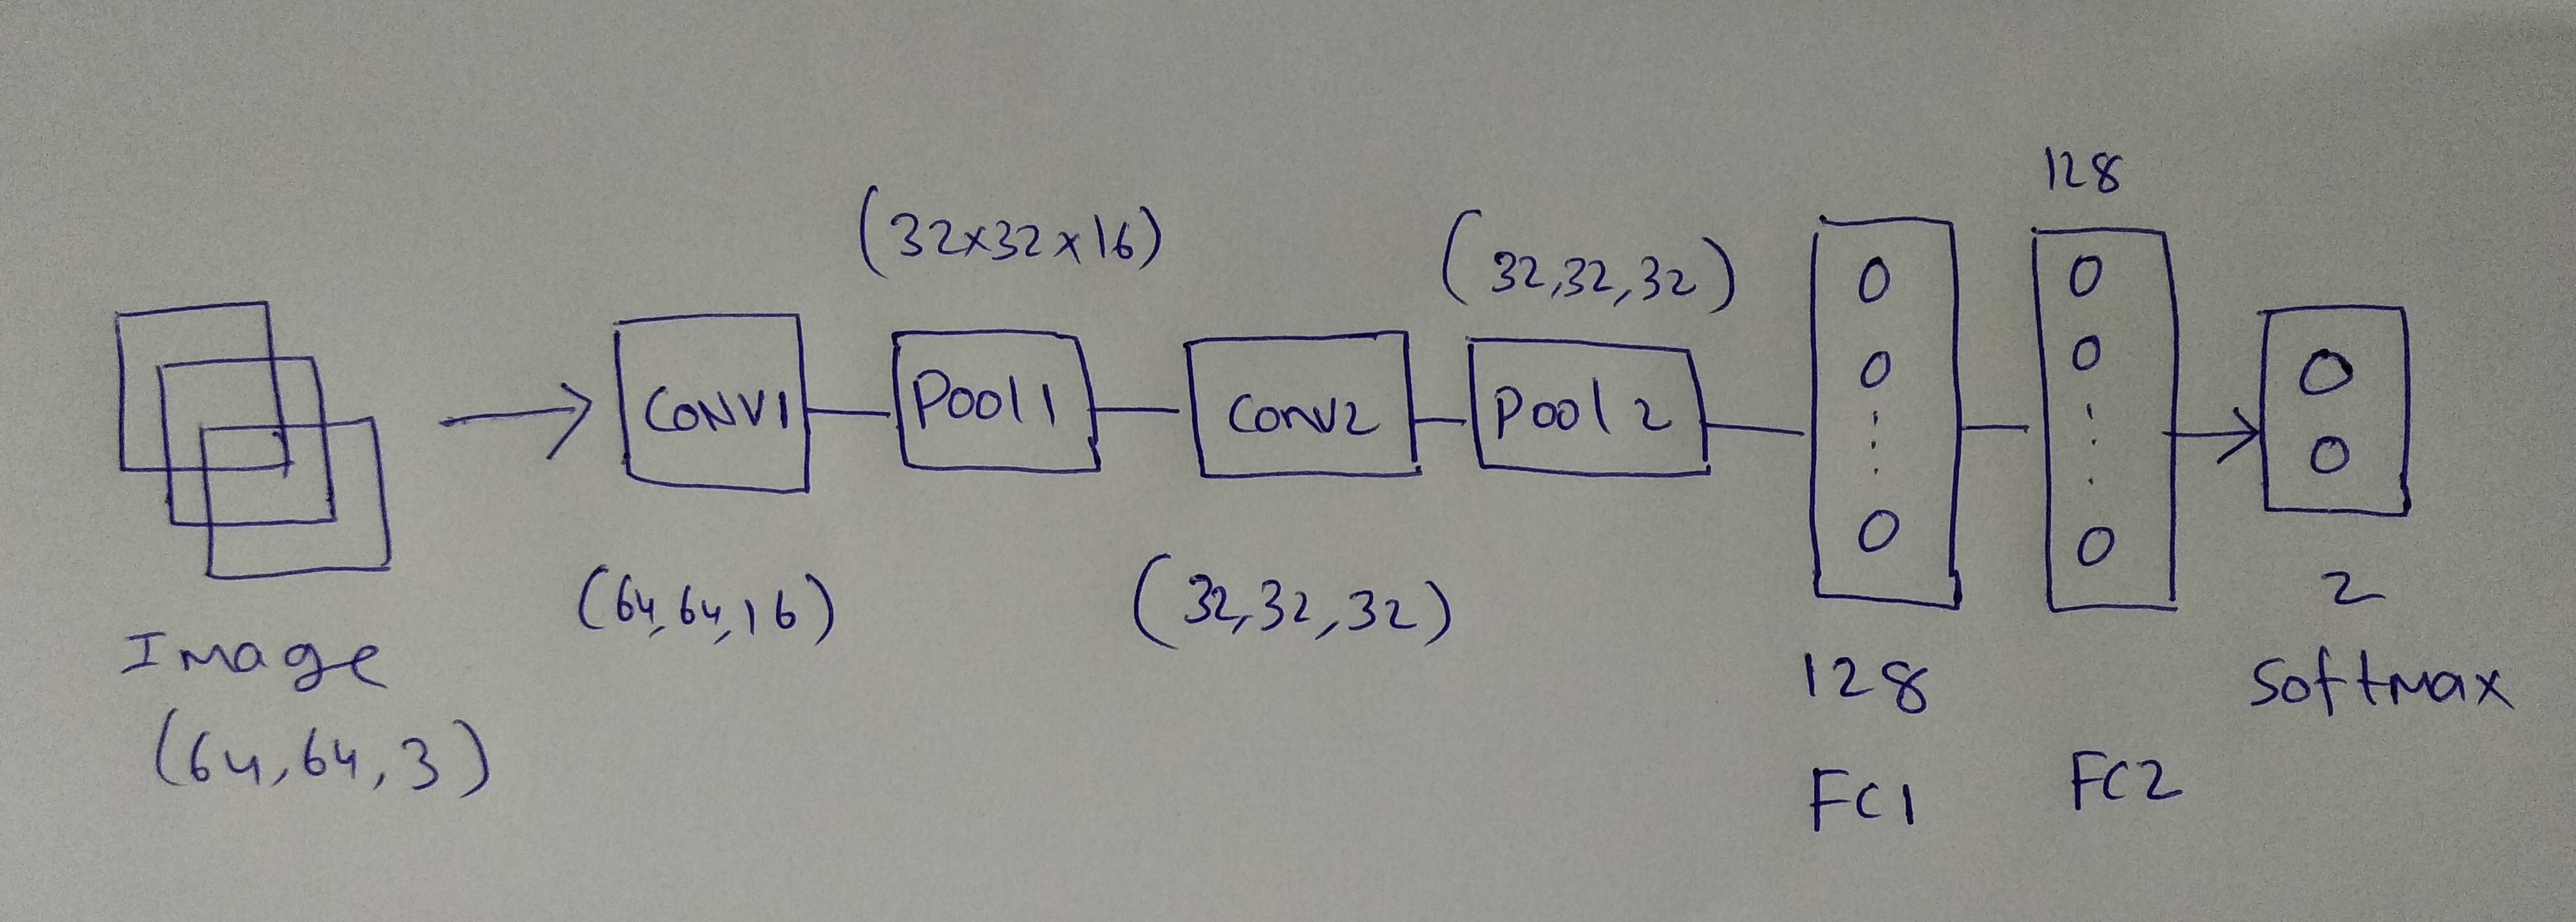

In [9]:
display(Image("images/model.jpg",width=850,height=850))

In [10]:
tf.reset_default_graph()
X = tf.placeholder("float", [None,64,64,3],name = "Input")
Y = tf.placeholder("float", [None,2])

logits = model(X)

total_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer=tf.train.GradientDescentOptimizer(0.05).minimize(total_cost)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
predict_outputs_Y = tf.argmax(logits, 1,name = "Argmax",output_type=tf.int32) # at predict time, evaluate the argmax
predict_softmaxs_Y = tf.nn.softmax(logits, 1,name ="Softmax")

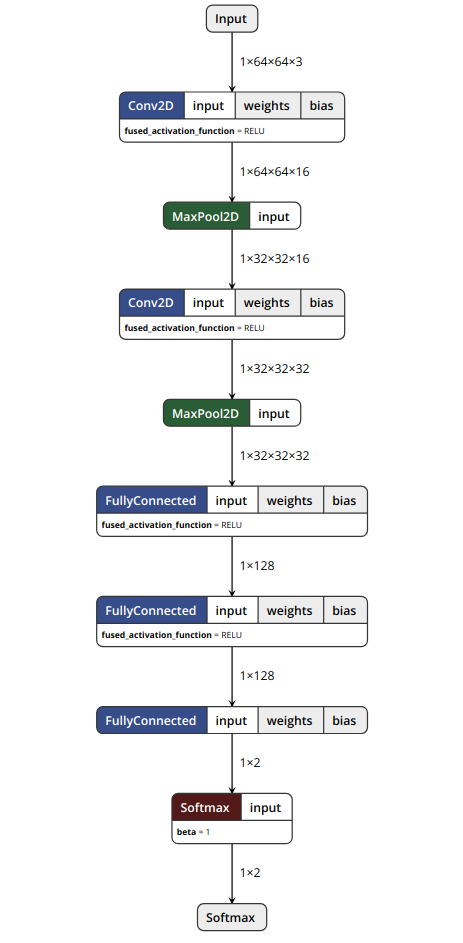

In [12]:
display(Image("images/vis_model.png",width=450,height=100))

In [13]:
def get_accuracy (inputs,labels,sess):
    return np.mean(np.argmax(labels, axis=1) == sess.run(predict_outputs_Y, feed_dict={X: inputs}))

In [25]:
def save_tf_model(sess,path,model_name):

    tf.train.write_graph(sess.graph_def, '.', path+model_name+'.pbtxt')
    print("model protobuf is stored successfully!")

    saver = tf.train.Saver()
    saver.save(sess, path+model_name)
    print("model checkpoint is saved successfully!")


def freeze_tf_model(path,model_name):

    input_graph_path = path+model_name+'.pbtxt'
    checkpoint_path = path+model_name
    input_saver_def_path = ""
    input_binary = False
    output_node_names = "Softmax"
    restore_op_name = "save/restore_all"
    filename_tensor_name = "save/Const:0"
    output_frozen_graph_name = path+'frozen_'+model_name+'.pb'
    clear_devices = True

    freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
                              input_binary, checkpoint_path, output_node_names,
                              restore_op_name, filename_tensor_name,
                              output_frozen_graph_name, clear_devices, "")
    
    print("model is freezed successfully!")
    
def convert_to_tflite():
    converter = tf.contrib.lite.TocoConverter.from_frozen_graph(path+'frozen_catsVSdogs.pb', ['Input'], ['Softmax'])
    tflite_model = converter.convert()
    open(path+"catsVSdogs.tflite", "wb").write(tflite_model)
    print("Model is written as tflite")

In [15]:
epochs = 15
epoch_cost = []
epoch_acc = []

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

print("Training started")

for epoch in range(epochs):
    total_batch_cost = 0
    acc_list = []
    
    for start, end in zip(range(0, len(trainX), 32), range(32, len(trainX)+1, 32)):
        feed_dict = {X : trainX[start:end] , Y : trainY[start:end]}
        _,y_hat,batch_cost = sess.run([optimizer,predict_softmaxs_Y,total_cost],feed_dict=feed_dict)
        
        acc = np.mean(np.argmax(trainY[start:end], axis=1) == np.argmax(y_hat,axis=1))
        acc_list.append(acc)
        total_batch_cost += batch_cost    
        
    print("Epoch cost is : {} and accuracy is : {} ".format(total_batch_cost,np.mean(acc_list)))

    epoch_cost.append(total_batch_cost)
    epoch_acc.append(np.mean(acc_list))

Training started
Epoch cost is : 541.5607509613037 and accuracy is : 0.504881562099872 
Epoch cost is : 534.0153052210808 and accuracy is : 0.5460947503201025 
Epoch cost is : 458.8487547636032 and accuracy is : 0.6853793213828425 
Epoch cost is : 397.2631815969944 and accuracy is : 0.7473591549295775 
Epoch cost is : 360.91951282322407 and accuracy is : 0.7782490396927016 
Epoch cost is : 326.58432225883007 and accuracy is : 0.807618437900128 
Epoch cost is : 289.61250022798777 and accuracy is : 0.8351072343149808 
Epoch cost is : 245.80698286741972 and accuracy is : 0.8681978233034571 
Epoch cost is : 203.5786295980215 and accuracy is : 0.8954065300896287 
Epoch cost is : 157.25556821748614 and accuracy is : 0.9222951344430218 
Epoch cost is : 118.83184525929391 and accuracy is : 0.9429817541613317 
Epoch cost is : 81.1156736924313 and accuracy is : 0.9619478233034571 
Epoch cost is : 66.33020728034899 and accuracy is : 0.96875 
Epoch cost is : 53.4866400193423 and accuracy is : 0.97

In [16]:
save_tf_model(sess,path,"catsVSdogs")
freeze_tf_model(path,"catsVSdogs")

model protobuf is stored successfully!
model checkpoint is saved successfully!
Instructions for updating:
Use tf.gfile.GFile.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model_outputs/catsVSdogs
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.
model is freezed successfully!


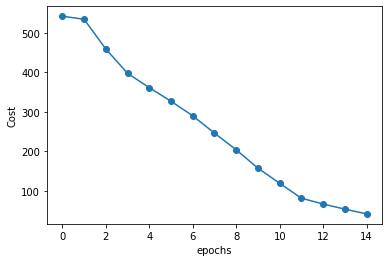

In [17]:
def visulize_cost(epoch_cost):
    indices = [i for i in range(len(epoch_cost))]
    plt.plot(indices,epoch_cost,marker="o")
    plt.xlabel("epochs")
    plt.ylabel("Cost")
    plt.show()
visulize_cost(epoch_cost)

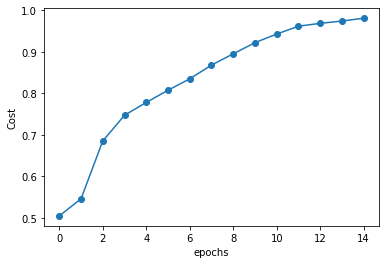

In [18]:
def visulize_acc(epoch_acc):
    indices = [i for i in range(len(epoch_acc))]
    plt.plot(indices,epoch_acc,marker="o")
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.show()
visulize_cost(epoch_acc)

In [20]:
path

'model_outputs/'

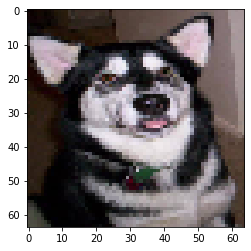

[array([[5.700503e-07, 9.999994e-01]], dtype=float32)]
0.00
1.00


In [21]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

graph = load_graph(path+'frozen_catsVSdogs.pb')
# for op in graph.get_operations():
#     print(op.name)
    
x = graph.get_tensor_by_name('import/Input:0')
y = graph.get_tensor_by_name('import/Softmax:0')

image = trainX[819]
plt.imshow(image)
plt.show()
image = np.expand_dims(image,axis=0)

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    output = sess.run([y],feed_dict={x:image})
    print(output)
    
    float_formatter = lambda x: "%.2f" % x
    
    for i in output[0][0]:
        print(float_formatter(i))

In [26]:
convert_to_tflite()

Model is written as tflite


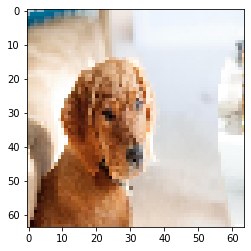

[[0.00462065 0.9953793 ]]


In [27]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.contrib.lite.Interpreter(path+"catsVSdogs.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
# change the following line to feed into your own data.
from tensorflow.keras.preprocessing import image
# input_data = trainX[0]
input_data = image.img_to_array(image.load_img("/home/mady/Desktop/dog_test.jpg", target_size=(64, 64)))/255

plt.imshow(input_data)
plt.show()

input_data = np.expand_dims(input_data,axis=0)

interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)